In [1]:
import pandas as pd
import numpy as np

In [2]:
df_tr = pd.read_csv('./train.csv', names=['class','text'])
df_te = pd.read_csv('./test.csv', names=['class','text'])

In [3]:
print('training size:', df_tr.shape)
print('test size:', df_te.shape)
df_tr.head()

training size: (560000, 2)
test size: (38000, 2)


,class,text
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


In [4]:
df_tr['class'].value_counts()

1    280000
2    280000
Name: class, dtype: int64

In [5]:
df_tr['class'] = df_tr['class'] - 1
df_te['class'] = df_te['class'] - 1

In [6]:
df_tr.head()

,class,text
0,0,"Unfortunately, the frustration of being Dr. Go..."
1,1,Been going to Dr. Goldberg for over 10 years. ...
2,0,I don't know what Dr. Goldberg was like before...
3,0,I'm writing this review to give you a heads up...
4,1,All the food is great here. But the best thing...


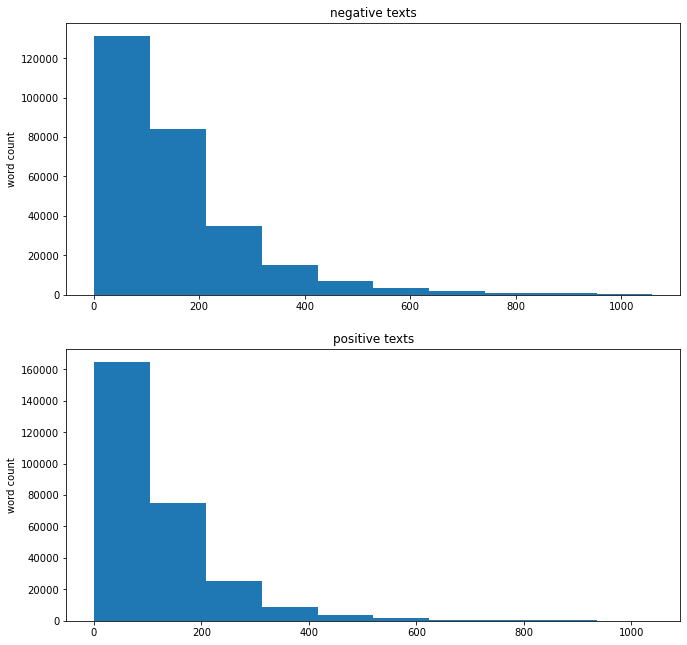

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(11, 11))
axs[0].hist([len(txt.split(' ')) for txt in df_tr['text'][df_tr['class'] == 0]])
axs[0].set_title("negative texts")
axs[0].set_ylabel("word count")
axs[1].hist([len(txt.split(' ')) for txt in df_tr['text'][df_tr['class'] == 1]])
axs[1].set_title("positive texts")
axs[1].set_ylabel("word count")
plt.show()

In [8]:
from transformers import BertTokenizerFast
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

In [9]:
df_tr.dtypes

class     int64
text     object
dtype: object

In [10]:
tokenizer.encode_plus(
    df_tr['text'][0],
    padding='max_length',
    add_special_tokens=True,
    max_length=70,
    return_attention_mask=True)

{'input_ids': [101, 6854, 1010, 1996, 9135, 1997, 2108, 2852, 1012, 18522, 1005, 1055, 5776, 2003, 1037, 9377, 1997, 1996, 3325, 1045, 1005, 2310, 2018, 2007, 2061, 2116, 2060, 7435, 1999, 16392, 1011, 1011, 2204, 3460, 1010, 6659, 3095, 1012, 2009, 3849, 2008, 2010, 3095, 3432, 2196, 6998, 1996, 3042, 1012, 2009, 2788, 3138, 1016, 2847, 1997, 5567, 4214, 2000, 2131, 2019, 3437, 1012, 2040, 2038, 2051, 2005, 2008, 2030, 4122, 2000, 3066, 2007, 2009, 1029, 1045, 2031, 2448, 2046, 2023, 3291, 2007, 2116, 2060, 7435, 1998, 1045, 2074, 2123, 1005, 1056, 2131, 2009, 1012, 2017, 2031, 2436, 3667, 1010, 2017, 2031, 5022, 2007, 2966, 3791, 1010, 2339, 3475, 1005, 1056, 3087, 10739, 1996, 3042, 1029, 2009, 1005, 1055, 4297, 25377, 2890, 10222, 19307, 1998, 2025, 2147, 1996, 12943, 17643, 21596, 1012, 2009, 1005, 1055, 2007, 9038, 2008, 1045, 2514, 2008, 1045, 2031, 2000, 2507, 2852, 1012, 18522, 1016, 3340, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [11]:
def bert_encode(data, maximum_length=None) :
    input_ids = []
    token_type_ids = []
    attention_masks = []

    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            padding='max_length',     #makes the short ones to max_length
            truncation=True,    #makes the long lones to max_length
            add_special_tokens=True,
            max_length=maximum_length,
            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        token_type_ids.append(encoded['token_type_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.asarray(input_ids), np.asarray(token_type_ids), np.asarray(attention_masks)

In [12]:
input_ids_tr, token_ids_tr, attention_masks_tr = bert_encode(df_tr['text'][:50000], 70)
input_ids_te, token_ids_te, attention_masks_te = bert_encode(df_te['text'][:50000], 70)

In [13]:
def create_model(bert_model):
    input_ids = layers.Input(shape=(70,), dtype='int32')
    token_ids = layers.Input(shape=(70,), dtype='int32')
    attention_masks = layers.Input(shape=(70,), dtype='int32')
    
    output = bert_model([input_ids, token_ids, attention_masks])[1]  #pooled, sequence
    
    #clf_output = output[:, 0, :]
    net = tf.keras.layers.Dense(32, activation='relu')(output)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(net)
    
    model = tf.keras.models.Model(inputs=[input_ids, token_ids, attention_masks], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [14]:
def create_model2(bert_model):
    input_ids = layers.Input(shape=(70,), dtype='int32')
    token_ids = tf.keras.Input(shape=(70,), dtype='int32')
    attention_masks = layers.Input(shape=(70,), dtype='int32')
    
    output = bert_model([input_ids=input_ids, token_type_ids=token_ids, attention_mask=attention_masks])
    output = output[1]
    
    output = tf.keras.layers.Dense(32, activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)

    output = tf.keras.layers.Dense(1, activation='sigmoid')(output)
    model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)
    model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy'])
    return model

SyntaxError: invalid syntax (<ipython-input-14-dd66afb09fb7>, line 6)

In [178]:
from transformers import TFBertModel

# module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
# bert_layer = hub.KerasLayer(module_url, trainable=True)

bert_model = TFBertModel.from_pretrained('bert-base-uncased')
model = create_model(bert_model)
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_41 (InputLayer)           [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_42 (InputLayer)           [(None, 70)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_11 (TFBertModel)  TFBaseModelOutputWit 109482240   input_40[0][0]                   
                                                                 input_41[0][0]             

In [183]:
model.fit([input_ids_tr[1000:1500], token_ids_tr[1000:1500], attention_masks_tr[1000:1500]],
          df_tr['class'][1000:1500], 
          validation_split = 0.2,
          epochs=4)

Epoch 1/4
13/13 [==============================] - 201s 16s/step - loss: 0.4375 - accuracy: 0.8225 - val_loss: 0.2995 - val_accuracy: 0.8600
Epoch 2/4
13/13 [==============================] - 183s 14s/step - loss: 0.2990 - accuracy: 0.8950 - val_loss: 0.3344 - val_accuracy: 0.8600
Epoch 3/4
13/13 [==============================] - 185s 14s/step - loss: 0.2370 - accuracy: 0.9175 - val_loss: 0.2753 - val_accuracy: 0.8800
Epoch 4/4
13/13 [==============================] - 183s 14s/step - loss: 0.1594 - accuracy: 0.9650 - val_loss: 0.2891 - val_accuracy: 0.8900


In [184]:
model.save_weights('saved_weights')

In [180]:
model.load_weights('saved_weights')

## Different way

In [22]:
import tensorflow_hub as hub
import tensorflow_text

tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2'
tfhub_handle_encoder = 'https://tfhub.dev/google/electra_small/2'

In [47]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
#     net = outputs['pooled_output']
#     net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation='relu', name='classifier')(outputs)
    return tf.keras.Model(text_input, net)

In [48]:
classifier_model = build_classifier_model()

ValueError: Layer classifier expects 1 input(s), but it received 15 input tensors. Inputs received: [<tf.Tensor 'Placeholder:0' shape=(None, 256) dtype=float32>, <tf.Tensor 'Placeholder_1:0' shape=(None, 128, 256) dtype=float32>, <tf.Tensor 'Placeholder_2:0' shape=(None, 128, 256) dtype=float32>, <tf.Tensor 'Placeholder_3:0' shape=(None, 128, 256) dtype=float32>, <tf.Tensor 'Placeholder_4:0' shape=(None, 128, 256) dtype=float32>, <tf.Tensor 'Placeholder_5:0' shape=(None, 128, 256) dtype=float32>, <tf.Tensor 'Placeholder_6:0' shape=(None, 128, 256) dtype=float32>, <tf.Tensor 'Placeholder_7:0' shape=(None, 128, 256) dtype=float32>, <tf.Tensor 'Placeholder_8:0' shape=(None, 128, 256) dtype=float32>, <tf.Tensor 'Placeholder_9:0' shape=(None, 128, 256) dtype=float32>, <tf.Tensor 'Placeholder_10:0' shape=(None, 128, 256) dtype=float32>, <tf.Tensor 'Placeholder_11:0' shape=(None, 128, 256) dtype=float32>, <tf.Tensor 'Placeholder_12:0' shape=(None, 128, 256) dtype=float32>, <tf.Tensor 'Placeholder_13:0' shape=(None, 256) dtype=float32>, <tf.Tensor 'Placeholder_14:0' shape=(None, 128, 256) dtype=float32>]

In [25]:
tf.keras.utils.plot_model(classifier_model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [42]:
classifier_model.compile(
    Adam(learning_rate=0.001), 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

classifier_model.fit(
    df_tr['text'][:1000], df_tr['class'][:1000],
    validation_split=0.2,
    epochs=5,
    batch_size=64)

Epoch 1/5
13/13 [==============================] - 232s 17s/step - loss: 8.4443 - accuracy: 0.4462 - val_loss: 6.9384 - val_accuracy: 0.5450
Epoch 2/5
13/13 [==============================] - 208s 16s/step - loss: 8.4443 - accuracy: 0.4462 - val_loss: 6.9384 - val_accuracy: 0.5450
Epoch 3/5
13/13 [==============================] - 205s 16s/step - loss: 8.4443 - accuracy: 0.4462 - val_loss: 6.9384 - val_accuracy: 0.5450
Epoch 4/5
 9/13 [===================>..........] - ETA: 1:04 - loss: 8.6571 - accuracy: 0.4323

KeyboardInterrupt: 

In [26]:
?classifier_model.fit

KeyError: (0, 0)